# Severstal: Steel Defect Detection

# 1. BUSINESS PROBLEM

## 1.1 DESCRIPTION

Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this competition will help identify defects.



Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously. The company recently created the country’s largest industrial data lake, with petabytes of data that were previously discarded. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.

The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.

In this competition, you’ll help engineers improve the algorithm by localizing and classifying surface defects on a steel sheet.

If successful, you’ll help keep manufacturing standards for steel high and enable Severstal to continue their innovation, leading to a stronger, more efficient world all around us.



## 1.2 SOURCES

DATA SOURCE: https://www.kaggle.com/c/severstal-steel-defect-detection/data



## 1.3 REAL WORLD / BUSINESS OBJECTIVES AND CONSTRAINTS

1. Classify the images based on the correct error.

2. Incorrect classification could affect customer and manufacturing teams.

3. No strict latency requirements.



# 2. MACHINE LEARNING OVERVIEW

## 2.1 DATA OVERVIEW

In this dataset, we will be predicting the location and type of defects found in steel manufacturing. Images are named with a unique ImageId. You must segment and classify the defects in the test set.

Each image may have no defects, a defect of a single class, or defects of multiple classes. For each image we must segment defects of each class (ClassId = [1, 2, 3, 4]).

The segment for each defect class will be encoded into a single row, even if there are several non-contiguous defect locations on an image. 


Files
train_images/ - folder of training images

test_images/ - folder of test images (you are segmenting and classifying these images)

train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])

sample_submission.csv - a sample submission file in the correct format; note, each ImageId 4 rows, one for each of the 4 defect classes



## 2.2 TYPE OF MACHINE LEARNING PROBLEM

This problem is a multi-label classification problem. Each IMAGE can have multiple DEFECTS that they can be classified as and are not mutually exclusive.

(http://scikit-learn.org/stable/modules/multiclass.html)

## 2.3 PERFOMANCE METRICS

This dataset is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

2∗|X∩Y||X|+|Y|

where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. 

# 3. EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import os
import json
import gc
import cv2
import keras
from keras import backend as K
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Activation, UpSampling2D, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121
from keras import optimizers
from keras.models import Sequential
from keras.callbacks import TensorBoard,Callback, ModelCheckpoint, ReduceLROnPlateau




Using TensorFlow backend.


In [0]:
'''train_count_mask = pd.read_pickle("/content/drive/My Drive/assignment 28/train_missing_count")
test_unique = pd.read_csv("/content/drive/My Drive/assignment 28/test_missing_count.csv")
train_df_final = pd.read_pickle("/content/drive/My Drive/assignment 28/train_df_final")
train_has_mask=pd.read_pickle("/content/drive/My Drive/assignment 28/train_has_mask")
test_df=pd.read_pickle("/content/drive/My Drive/assignment 28/test_split")'''


In [0]:
train_df = pd.read_csv("/content/drive/My Drive/assignment 28/train.csv")

In [0]:
test_df = pd.read_csv("/content/drive/My Drive/assignment 28/sample_submission.csv")

In [0]:
train_df.head()

ImageId_ClassId                                      EncodedPixels
0  0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg_2                                                NaN
2  0002cc93b.jpg_3                                                NaN
3  0002cc93b.jpg_4                                                NaN
4  00031f466.jpg_1                                                NaN

In [0]:
test_df.head()

ImageId_ClassId EncodedPixels
0  004f40c73.jpg_1           1 1
1  004f40c73.jpg_2           1 1
2  004f40c73.jpg_3           1 1
3  004f40c73.jpg_4           1 1
4  006f39c41.jpg_1           1 1

In [0]:
#Separating The Image Id into a separate column
test_df['ImageId'] = test_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])

In [0]:
test_df.head()

ImageId_ClassId EncodedPixels        ImageId
0  004f40c73.jpg_1           1 1  004f40c73.jpg
1  004f40c73.jpg_2           1 1  004f40c73.jpg
2  004f40c73.jpg_3           1 1  004f40c73.jpg
3  004f40c73.jpg_4           1 1  004f40c73.jpg
4  006f39c41.jpg_1           1 1  006f39c41.jpg

In [0]:
import pickle
test_df.to_pickle("/content/drive/My Drive/assignment 28/test_split")

In [0]:
print("Number of data in training data points : ", len(train_df))

Number of data in training data points :  50272


In [0]:
print("Images without defects  : ", train_df["EncodedPixels"].isna().sum())

Images without defects  :  43177


In [0]:
print("Images with defects  : ", len(train_df)-train_df["EncodedPixels"].isna().sum())

Images with defects  :  7095


We can see that each image has 4 rows of data with 4 different defect class id so we will try to separate that.

In [0]:
data_new = train_df.ImageId_ClassId.str.split("_",expand=True)
data_new.columns=["ImageId", "DefectClass"]
data_final = pd.concat([data_new, train_df.EncodedPixels],axis=1)
data_final.head()

ImageId DefectClass                                      EncodedPixels
0  0002cc93b.jpg           1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg           2                                                NaN
2  0002cc93b.jpg           3                                                NaN
3  0002cc93b.jpg           4                                                NaN
4  00031f466.jpg           1                                                NaN

## 3.1 Defect Masks per Image

In [0]:
# grouping the defects by image id so we can plot it.

train_df_defect = data_final[data_final["EncodedPixels"].notnull()]
class_per_image =  train_df_defect["DefectClass"].groupby(train_df_defect["ImageId"]).count()

Numeric info : 

Class 1 :  6239
Class 2 :  425
Class 3 :  2
Class 4 :  0


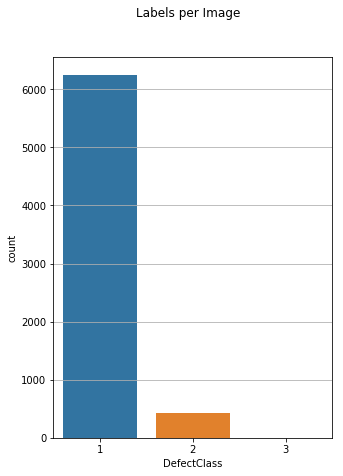

In [0]:
plt.figure(figsize=(5,7))
plt.suptitle("Labels per Image")
plt.grid()
sns.countplot(class_per_image)
print("Numeric info : \n")
print("Class 1 : ",len(class_per_image[class_per_image == 1]))
print("Class 2 : ",len(class_per_image[class_per_image == 2]))
print("Class 3 : ",len(class_per_image[class_per_image == 3]))
print("Class 4 : ",len(class_per_image[class_per_image == 4]))

We can see that this is a multi label classification problem. Majority of the  images have only 1 defect with two images having 3 defects.

## 3.2 Defects Frequency

In [0]:
data_final['DefectClass'].value_counts()

2    12568
4    12568
3    12568
1    12568
Name: DefectClass, dtype: int64

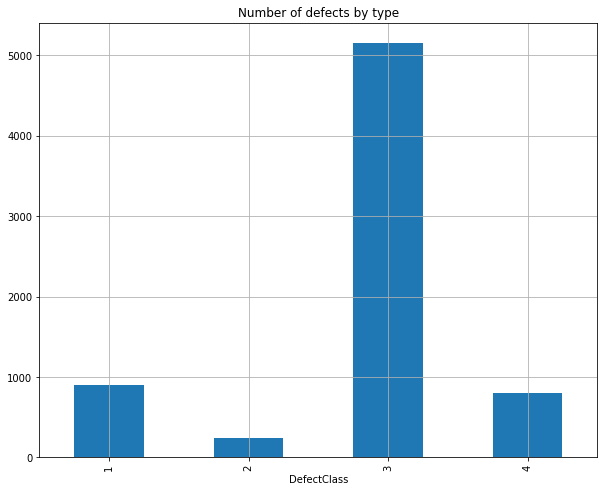

In [0]:
data_final.groupby('DefectClass')['EncodedPixels'].count().plot(kind='bar',
                                                            title='Number of defects by type', 
                                                            figsize=(10, 8),
                                                            grid=True);

We can observe that the most commonly observed defect is of class 3 and the least observed defect is of class 2.

In [0]:
import pickle
data_final.to_pickle("/content/drive/My Drive/assignment 28/data_final")

In [0]:
# finding the percentage of images with defect masks present.

percent=data_final
percent=percent.fillna(0)
total_images = len(percent['ImageId'].unique())
defective = len(percent[percent['EncodedPixels'] != 0]['ImageId'].unique())
print('Percentage of defective images: %s' % (defective / total_images))

Percentage of defective images: 0.5303946530872056


## 3.3 Image Visualization

In [0]:
# https://www.kaggle.com/kenmatsu4/visualize-steel-defect
# visualizing the defect masks in the training data.
from glob import glob
from PIL import Image

def defeat_position(img_id, class_id):
    
    train_s = train_df[train_df.ImageId_ClassId==f"{img_id}_{class_id}"]
    #print(train_s.EncodedPixels.values[0])
    
    if not isinstance(train_s.EncodedPixels.values[0], str) and np.isnan(train_s.EncodedPixels.values[0]):
        return np.array([]), np.array([])
    
    encoded_pixels = [int(i) for i in train_s.EncodedPixels.values[0].split(" ")]

    pixcels = []
    for pos, offset in zip(encoded_pixels[0:len(encoded_pixels):2], encoded_pixels[1:len(encoded_pixels):2]):
        pixcels.extend(list(range(pos, pos+offset)))
    pixcels = np.array(pixcels)    
    x = pixcels // 256
    y = pixcels % 256  
    return x, y
  
def show_segmented_image(img_file, x, y, class_id):
    im = np.array(Image.open(img_file))
    
    if class_id == 4:
        im[y, x, 1] += 50
        im[y, x, 2] += 50
    else:
        im[y, x, class_id-1] += 50
        
    im = np.clip(im, 0, 255)

    plt.figure(figsize=(15,5))
    plt.imshow(im)
    plt.xticks([]);plt.yticks([]);
    plt.show()
    
def visualize_defect(class_id, n_show=20):
    cnt = 0
    for img_file in train_files:
        img_id = img_file.split('/')[-1]
        x, y = defeat_position(img_id, class_id)
        if len(x)==0:
            continue
        print(img_file, class_id)
        show_segmented_image(img_file, x, y, class_id)
        cnt += 1
        if cnt > n_show: break

In [0]:
train_files = np.sort(glob("/content/drive/My Drive/assignment 28/train_images/*"))

Defects of class 1.

/content/drive/My Drive/assignment 28/train_images/0002cc93b.jpg 1


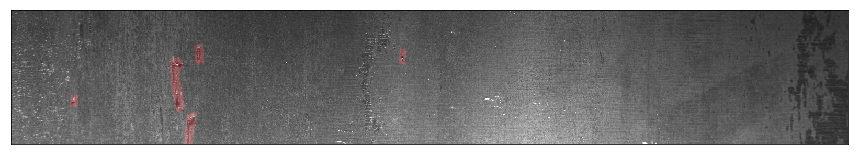

/content/drive/My Drive/assignment 28/train_images/000a4bcdd.jpg 1


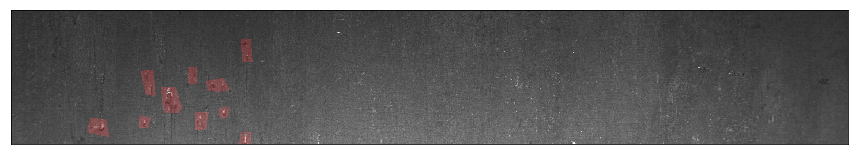

/content/drive/My Drive/assignment 28/train_images/002fc4e19.jpg 1


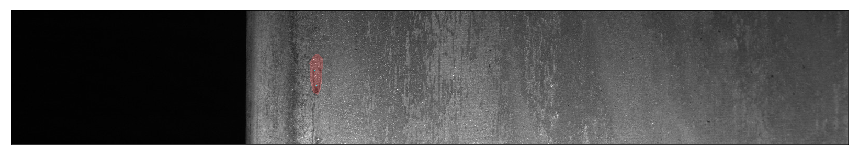

/content/drive/My Drive/assignment 28/train_images/008ef3d74.jpg 1


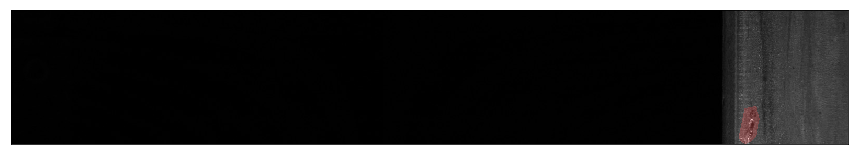

/content/drive/My Drive/assignment 28/train_images/00ac8372f.jpg 1


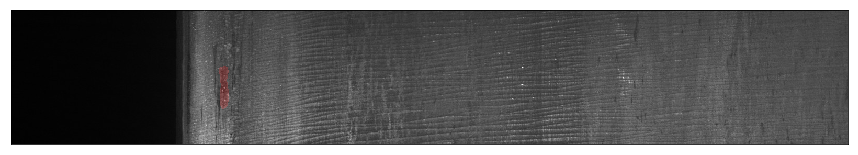

/content/drive/My Drive/assignment 28/train_images/00bc01bfe.jpg 1


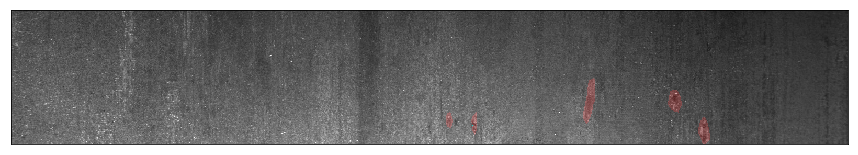

In [0]:
visualize_defect(1, n_show=5)

Defects of class 2.

/content/drive/My Drive/assignment 28/train_images/002fc4e19.jpg 2


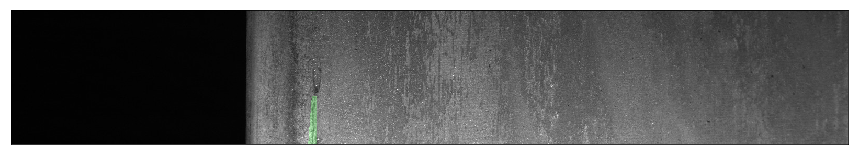

/content/drive/My Drive/assignment 28/train_images/008ef3d74.jpg 2


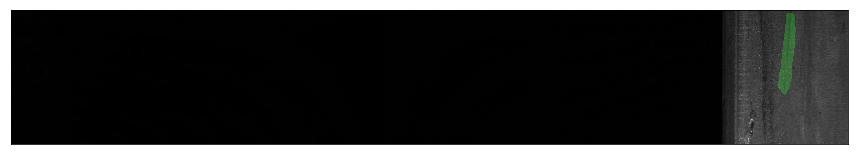

/content/drive/My Drive/assignment 28/train_images/00ac8372f.jpg 2


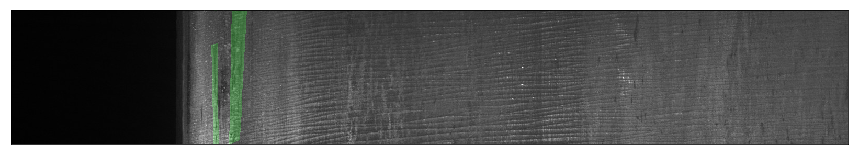

/content/drive/My Drive/assignment 28/train_images/00c88fed0.jpg 2


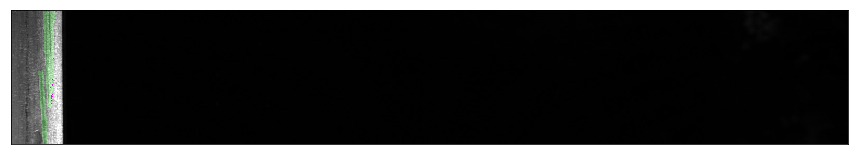

/content/drive/My Drive/assignment 28/train_images/026183d85.jpg 2


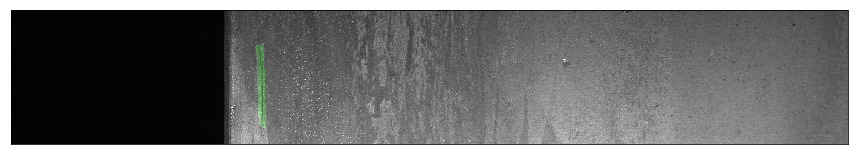

/content/drive/My Drive/assignment 28/train_images/0405e7c54.jpg 2


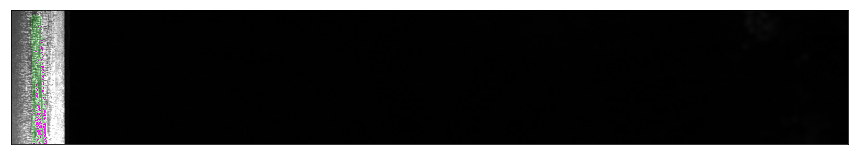

In [0]:
visualize_defect(2, n_show=5)

Defects of class 3.

/content/drive/My Drive/assignment 28/train_images/0007a71bf.jpg 3


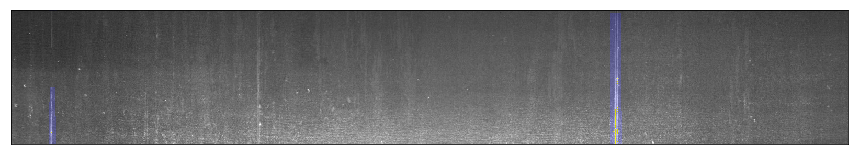

/content/drive/My Drive/assignment 28/train_images/0014fce06.jpg 3


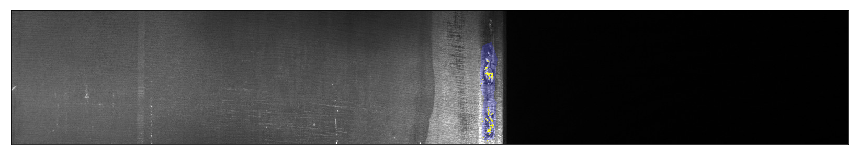

/content/drive/My Drive/assignment 28/train_images/0025bde0c.jpg 3


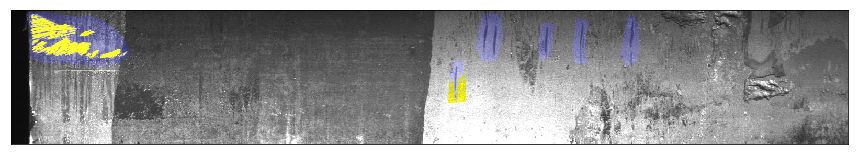

/content/drive/My Drive/assignment 28/train_images/0046839bd.jpg 3


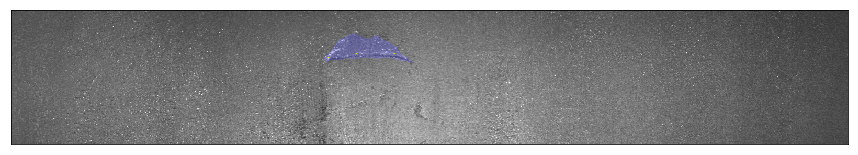

/content/drive/My Drive/assignment 28/train_images/005d86c25.jpg 3


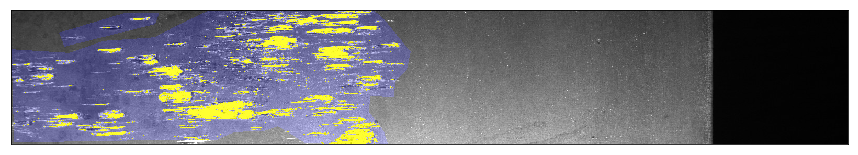

/content/drive/My Drive/assignment 28/train_images/005f02e20.jpg 3


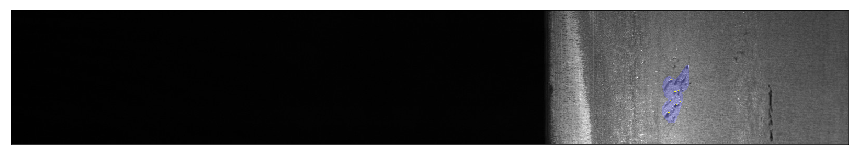

In [0]:
visualize_defect(3, n_show=5)

Defects of class 4.

/content/drive/My Drive/assignment 28/train_images/000f6bf48.jpg 4


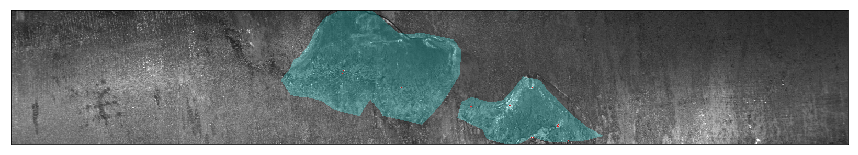

/content/drive/My Drive/assignment 28/train_images/0025bde0c.jpg 4


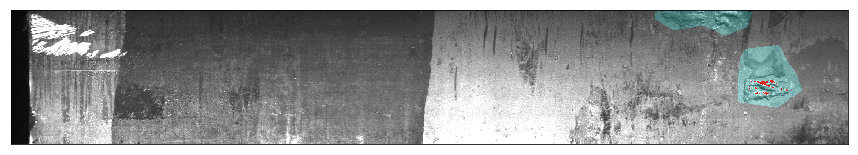

/content/drive/My Drive/assignment 28/train_images/002af848d.jpg 4


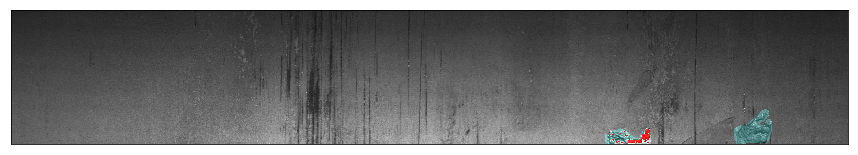

/content/drive/My Drive/assignment 28/train_images/0030401a5.jpg 4


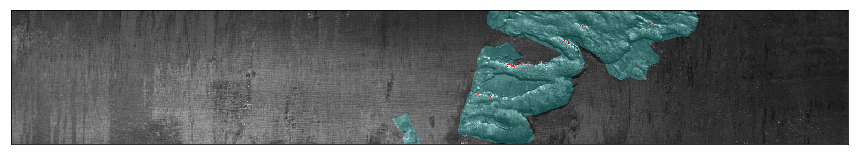

/content/drive/My Drive/assignment 28/train_images/008621629.jpg 4


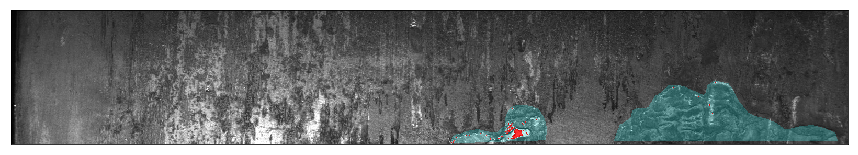

/content/drive/My Drive/assignment 28/train_images/012f26693.jpg 4


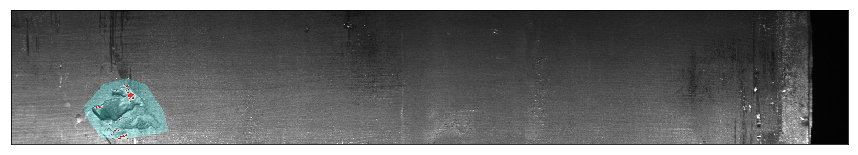

In [0]:
visualize_defect(4, n_show=5)

## OBSERVATONS

1) We have a total of 50272 images out of which 7095 show images with defects.

2) Majority of the images show only 1 defect with a few images having upto 3 defects, which tells us that this is a multi-label classification problem.

3) Defects of class 3 are the most commonly occuring by a big margin which tells us that the data is imbalanced.

4) All the images are of the same size.

5) 53% of the images are defective.

# 4. DATA MODELING AND CLEANING

## 4.1 DATA CLEANING

In [0]:
data_final.head()

ImageId DefectClass                                      EncodedPixels
0  0002cc93b.jpg           1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0002cc93b.jpg           2                                                NaN
2  0002cc93b.jpg           3                                                NaN
3  0002cc93b.jpg           4                                                NaN
4  00031f466.jpg           1                                                NaN

In [0]:
data_final['isNan'] = pd.isna(data_final['EncodedPixels'])

Creating a new column which shows if there is a mask present or not.

In [0]:
data_final.head()

ImageId  ...  isNan
0  0002cc93b.jpg  ...  False
1  0002cc93b.jpg  ...   True
2  0002cc93b.jpg  ...   True
3  0002cc93b.jpg  ...   True
4  00031f466.jpg  ...   True

[5 rows x 4 columns]

In [0]:
import pickle
data_final.to_pickle("/content/drive/My Drive/assignment 28/data_final")

Count of missing masks

In [0]:
# adding a column which tellus us how many masks are there per image.
# adding a boolean column which tells us if that image contains all 4 possible masks/defects.
train_count_mask = data_final.groupby(by='ImageId', axis=0).agg('sum')
train_count_mask.reset_index(inplace=True)
train_count_mask.rename(columns={'isNan': 'No_of_Mask'}, inplace=True)
train_count_mask['No_of_Mask'] = train_count_mask['No_of_Mask'].astype(np.int32)
train_count_mask['All_mask'] = (train_count_mask['No_of_Mask'] == 4).astype(int)


In [0]:

train_count_mask.head()

ImageId  No_of_Mask  All_mask
0  0002cc93b.jpg           3         0
1  00031f466.jpg           4         1
2  000418bfc.jpg           4         1
3  000789191.jpg           4         1
4  0007a71bf.jpg           3         0

In [0]:
unique_test_images = test_df['ImageId_ClassId'].apply(
    lambda x: x.split('_')[0]
).unique()


Removing all the duplicate image names in test data.

In [0]:
test_unique = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_unique.shape)
test_unique.head()

(1801, 1)


ImageId
0  004f40c73.jpg
1  006f39c41.jpg
2  00b7fb703.jpg
3  00bbcd9af.jpg
4  0108ce457.jpg

## 4.2 DATA MODELLING

In [0]:
#Initially tried to work wihtout resizing images but it led to a Resource exhausted: OOM error.  
#Resizing images as Resource exhausted: OOM issue is being created.
#https://www.kaggle.com/virajbagal/severstal-unet-resnet18-in-keras

def load_img(code, base, resize=True):
    path = f'{base}/{code}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (256, 512))
    
    return img

def validate_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
train_path = '/content/drive/My Drive/assignment 28/train_images'
validate_path(train_path)

for code in tqdm(train_count_mask['ImageId']):
    img = load_img(
        code,
        base='/content/drive/My Drive/assignment 28/train_images'
    )
    

In [4]:
# https://keras.io/preprocessing/image/
#data augmentation using image generator

  
def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )

def create_test_gen():
    return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
        test_unique,
        directory='/content/drive/My Drive/assignment 28/test_images',
        x_col='ImageId',
        class_mode=None,
        target_size=(256, 512),
        batch_size=12,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_count_mask, 
        directory='/content/drive/My Drive/assignment 28/train_images',
        x_col='ImageId', 
        y_col='All_mask', 
        class_mode='other',
        target_size=(256, 512),
        batch_size=12,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 10682 validated image filenames.
Found 1885 validated image filenames.
Found 1801 validated image filenames.


# 5. CLASSIFYING IF DEFECTIVE OR NOT

Initially we will be training a DenseNet model to differentiate between images which have atleast 1 defect and which have no defect.




## 5.1 DENSENET MODEL 1

In [0]:
#Architecture: https://www.kaggle.com/phmagic/keras-densenet121-multi-label-baseline
from keras.applications import DenseNet121
def build_model():
    base_model = DenseNet121(weights=None, include_top=False, input_shape=(256,512,3))
    x = AveragePooling2D(pool_size=(3,3), name='avg_pool')(base_model.output)
    x = Flatten()(x)
    x = Dense(512, activation='relu', name='dense_post_pool')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid', name='predictions')(x)
    model = Model(inputs=base_model.input, output=output)
    return model

In [0]:
model = build_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 262, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 256, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 256, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
#https://www.kaggle.com/xhlulu/severstal-simple-2-step-pipeline/output
total_steps = train_count_mask.shape[0] / 12

checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6,
                                         patience=2, verbose=1)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=10, verbose=1,use_multiprocessing=True, workers=6,
    callbacks=[checkpoint, reduce_learning_rate ]
)

Epoch 1/10
891/890 [==============================] - 906s 1s/step - loss: 0.5361 - acc: 0.7160 - val_loss: 0.5021 - val_acc: 0.7257

Epoch 00001: val_acc improved from -inf to 0.72573, saving model to /content/drive/My Drive/assignment 28/epochs:001-val_acc:0.726.hdf5
Epoch 2/10
890/890 [============================>.] - ETA: 0s - loss: 0.5214 - acc: 0.7287
Epoch 00001: val_acc improved from -inf to 0.72573, saving model to /content/drive/My Drive/assignment 28/epochs:001-val_acc:0.726.hdf5
891/890 [==============================] - 865s 971ms/step - loss: 0.5216 - acc: 0.7284 - val_loss: 0.6611 - val_acc: 0.6175

Epoch 00002: val_acc did not improve from 0.72573
Epoch 3/10
891/890 [==============================] - 866s 972ms/step - loss: 0.4984 - acc: 0.7446 - val_loss: 0.5367 - val_acc: 0.6812

Epoch 00003: val_acc did not improve from 0.72573

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
890/890 [============================>.] - ETA:

We achieved a best accuracy of 0.816 over 10 epochs.

## 5.2 DENSENET MODEL 2

In [0]:
from keras.applications import DenseNet121
def build_model():
    densenet = DenseNet121(
        include_top=False,
        input_shape=(256,512,3),
        weights='imagenet'
    )
    
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [0]:
model1 = build_model()
model1.summary()









A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4912a53fbd2a69346e7f2c0b5ec8c6d3 so we will re-download the data.
30015488/30011760 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 16, 1024)       7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
___________________________________________________________

In [0]:
total_steps = train_count_mask.shape[0] / 12

checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/model_dense2.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1)


history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=10, verbose=1,use_multiprocessing=True, workers=6,
    callbacks=[checkpoint, reduce_learning_rate]
)

Epoch 1/10
891/890 [==============================] - 887s 996ms/step - loss: 0.3933 - acc: 0.8150 - val_loss: 0.3794 - val_acc: 0.8228

Epoch 00001: val_acc improved from -inf to 0.82281, saving model to /content/drive/My Drive/assignment 28/model_dense2.h5
Epoch 2/10
891/890 [==============================] - 866s 972ms/step - loss: 0.3834 - acc: 0.8178 - val_loss: 0.4219 - val_acc: 0.7676

Epoch 00002: val_acc did not improve from 0.82281
Epoch 3/10
890/890 [============================>.] - ETA: 0s - loss: 0.3779 - acc: 0.8243
Epoch 00002: val_acc did not improve from 0.82281
891/890 [==============================] - 865s 971ms/step - loss: 0.3780 - acc: 0.8243 - val_loss: 0.3265 - val_acc: 0.8440

Epoch 00003: val_acc improved from 0.82281 to 0.84403, saving model to /content/drive/My Drive/assignment 28/model_dense2.h5
Epoch 4/10
891/890 [==============================] - 866s 972ms/step - loss: 0.3764 - acc: 0.8255 - val_loss: 0.3604 - val_acc: 0.8159

Epoch 00004: val_acc did 

We can see that our second dense net model gave us a higher accuracy.

In [0]:
filter_model=load_model('/content/drive/My Drive/assignment 28/model_dense2.h5')










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### OBSERVATIONS

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Val_Loss", "Val_Acc"]

x.add_row(["Dense Net Model 1", 0.355 , 0.824])
x.add_row(["Dense Net Model 2",  0.30 , 0.861])



print(x)

+-------------------+----------+---------+
|     Model Name    | Val_Loss | Val_Acc |
+-------------------+----------+---------+
| Dense Net Model 1 |  0.355   |  0.824  |
| Dense Net Model 2 |   0.3    |  0.861  |
+-------------------+----------+---------+


We used 2 dense net models to classify if an image has a defect or not. Our model 2 performed well and hence we will use that below.

## 5.3 PREDICTING ON DENSE NET MODEL

Filtering the images with atleast 1 defect present from the test data.

In [0]:
filter_test_set = filter_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

151/151 [==============================] - 546s 4s/step


In [0]:
# create a new column with the probability values
test_unique['missing_per'] = filter_test_set

In [0]:
test_unique.head()

ImageId  missing_per
0  004f40c73.jpg     0.564236
1  006f39c41.jpg     0.716079
2  00b7fb703.jpg     1.000000
3  00bbcd9af.jpg     0.003078
4  0108ce457.jpg     0.482020

In [0]:
train_count_mask.to_csv('/content/drive/My Drive/assignment 28/train_missing_count.csv', index=False)
test_unique.to_csv('/content/drive/My Drive/assignment 28/test_missing_count.csv', index=False)

In [0]:
train_count_mask.to_pickle("/content/drive/My Drive/assignment 28/train_missing_count")

In [0]:
len(test_unique)

1801

In [0]:
# filter imges based on probability to see if they are defective
filtered_test_imgs = test_unique[test_unique['missing_per'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()

(881, 2)


ImageId  missing_per
3  00bbcd9af.jpg     0.003078
4  0108ce457.jpg     0.482020
5  0109b68ec.jpg     0.000454
6  010ec96b4.jpg     0.366091
9  01b47d973.jpg     0.112643

In [0]:
# filtering all the images which do not have a mask
filtered_mask = test_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
test_withmask = test_df[filtered_mask].copy()
test_without_mask = test_df[~filtered_mask].copy()
test_without_mask['EncodedPixels'] = test_without_mask['EncodedPixels'].apply(
    lambda x: ' ')

test_withmask.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)

print(test_withmask.shape)
print(test_without_mask.shape)

test_withmask.head()

In [0]:
test_without_mask.head()

ImageId_ClassId EncodedPixels        ImageId
0  004f40c73.jpg_1                004f40c73.jpg
1  004f40c73.jpg_2                004f40c73.jpg
2  004f40c73.jpg_3                004f40c73.jpg
3  004f40c73.jpg_4                004f40c73.jpg
4  006f39c41.jpg_1                006f39c41.jpg

# 6. CLASSIFYING AMONG 4 DEFECTIVE LABELS

Since we have separated the defective and non defective images from test data, we classify the defective images into one of the 4 classes.

In [0]:
#utility functions to convert mask to encoded value and viceversa and build masks
#https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate#618761
#https://www.kaggle.com/karanjakhar/starter-siim

def mask2rle(img):
    
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape):
    depth = len(rles)
    masks = np.zeros((*input_shape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, input_shape)
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

In [0]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# to generate data and feed it directly to gpu to speed up the process
  
  class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/drive/My Drive/assignment 28/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [0]:
# filtering all the train data that have masks and removing the one without masks since out test data has already been filtered
train_df_final=train_df
train_df_final['ImageId'] = train_df_final['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
train_df_final['ClassId'] = train_df_final['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
train_df_final['hasMask'] = ~ train_df_final['EncodedPixels'].isna()

print(train_df_final.shape)
train_df_final.head()

(50272, 5)


ImageId_ClassId  ... hasMask
0  0002cc93b.jpg_1  ...    True
1  0002cc93b.jpg_2  ...   False
2  0002cc93b.jpg_3  ...   False
3  0002cc93b.jpg_4  ...   False
4  00031f466.jpg_1  ...   False

[5 rows x 5 columns]

In [0]:
train_df_final.to_pickle("/content/drive/My Drive/assignment 28/train_df_final")

In [0]:
mask_count_df = train_df_final.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(12568, 2)


ImageId  hasMask
10803  db4867ee8.jpg      3.0
11776  ef24da2ba.jpg      3.0
6284   7f30b9c64.jpg      2.0
9421   bf0c81db6.jpg      2.0
9615   c314f43f3.jpg      2.0

In [0]:
train_has_mask = mask_count_df[mask_count_df['hasMask'] > 0]
train_has_mask.head()

ImageId  hasMask
10803  db4867ee8.jpg      3.0
11776  ef24da2ba.jpg      3.0
6284   7f30b9c64.jpg      2.0
9421   bf0c81db6.jpg      2.0
9615   c314f43f3.jpg      2.0

In [0]:
len(train_has_mask)

6666

In [0]:
train_has_mask.to_pickle("/content/drive/My Drive/assignment 28/train_has_mask")

## 6.1 SIMPLE MODEL

In [0]:
# evaluation metric
#https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
# https://keras.io/preprocessing/image/

BATCH_SIZE = 16

train_data, val_data = train_test_split(
    train_has_mask.index,
    random_state=100, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_data, 
    df=mask_count_df,
    target_df=train_df_final,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_data, 
    df=mask_count_df,
    target_df=train_df_final,
    batch_size=BATCH_SIZE, 
    n_classes=4
)





In [0]:
#Simple model
def build_model(input_shape):
    inputs = Input(input_shape)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c1)
    c3 = Conv2D(8, (3, 3), activation='relu', padding='same') (c2)
    outputs = Conv2D(4, (3, 3), activation='sigmoid', padding='same') (c3)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model    
 

In [0]:
model_simple = build_model((256, 1600, 1))
model_simple.summary()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 256, 1600, 1)      0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 1600, 16)     160       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 256, 1600, 32)     4640      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 256, 1600, 8)      2312      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 256, 1600, 4)      292       
Total params: 7,404
Trainable params: 7,404
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/model_simple.h5', 
    monitor='val_dice_coef', 
    verbose=2, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)

history = model_simple.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=True, workers=5,
    epochs=20,verbose=2
)

Epoch 1/20
 - 357s - loss: 0.0868 - dice_coef: 0.0186 - val_loss: 0.0403 - val_dice_coef: 0.0217

Epoch 00001: val_dice_coef improved from -inf to 0.02167, saving model to /content/drive/My Drive/assignment 28/model_simple.h5
Epoch 2/20

 - 365s - loss: 0.0382 - dice_coef: 0.0245 - val_loss: 0.0403 - val_dice_coef: 0.0198

Epoch 00002: val_dice_coef did not improve from 0.02167
Epoch 3/20
 - 367s - loss: 0.0376 - dice_coef: 0.0288 - val_loss: 0.0379 - val_dice_coef: 0.0392

Epoch 00003: val_dice_coef improved from 0.02167 to 0.03917, saving model to /content/drive/My Drive/assignment 28/model_simple.h5
Epoch 4/20
 - 366s - loss: 0.0367 - dice_coef: 0.0359 - val_loss: 0.0378 - val_dice_coef: 0.0386

Epoch 00004: val_dice_coef did not improve from 0.03917
Epoch 5/20
 - 380s - loss: 0.0361 - dice_coef: 0.0419 - val_loss: 0.0391 - val_dice_coef: 0.0341

Epoch 00005: val_dice_coef did not improve from 0.03917
Epoch 6/20
 - 373s - loss: 0.0360 - dice_coef: 0.0436 - val_loss: 0.0369 - val_dic

## 6.2 TRAINING U-NET MODEL 1 FOR CLASSIFICATION

In [0]:
#https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [0]:
model = build_model((256, 1600, 1))
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 1600, 8) 80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 1600, 8) 584         conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 800, 8)  0           conv2d_25[0][0]               

In [0]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/unet_1.h5', 
    monitor='val_dice_coef', 
    verbose=2, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss ',
    patience=2,
    verbose=1,
    min_lr=1e-6, cooldown=2
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr],
    use_multiprocessing=True, workers=6,
    epochs=20,verbose=2
)


Epoch 1/20


 - 493s - loss: 0.0941 - dice_coef: 0.0252 - val_loss: 0.0395 - val_dice_coef: 0.0259

Epoch 00001: val_dice_coef improved from -inf to 0.02586, saving model to /content/drive/My Drive/assignment 28/unet_1.h5
Epoch 2/20
 - 446s - loss: 0.0352 - dice_coef: 0.0461 - val_loss: 0.0358 - val_dice_coef: 0.0491

Epoch 00002: val_dice_coef improved from 0.02586 to 0.04913, saving model to /content/drive/My Drive/assignment 28/unet_1.h5
Epoch 3/20

Epoch 00002: val_dice_coef improved from 0.02586 to 0.04913, saving model to /content/drive/My Drive/assignment 28/unet_1.h5
 - 449s - loss: 0.0324 - dice_coef: 0.0733 - val_loss: 0.0329 - val_dice_coef: 0.0962

Epoch 00003: val_dice_coef improved from 0.04913 to 0.09623, saving model to /content/drive/My Drive/assignment 28/unet_1.h5
Epoch 4/20
 - 452s - loss: 0.0291 - dice_coef: 0.1428 - val_loss: 0.0266 - val_dice_coef: 0.2306

Epoch 00004: val_dice_coef improved from 0.09623 to 0.23063, saving model to /content/drive/My Drive/assign

## 6.3 TRAINING U-NET MODEL 2 FOR CLASSIFICATION

In [0]:
def build_model(input_shape):
    inputs = Input(input_shape)
 
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c6)

    c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c8)
    
    bn = Conv2D(64, (3, 3), activation='relu', padding='same') (p5)
    
    u1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (bn)
    u1 = concatenate([u1, c8])
    
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (u1)
    
    u2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
    u2 = concatenate([u2, c6])
    
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same') (u2)
    
    u3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
    u3 = concatenate([u3, c4])
    
    c11 = Conv2D(32, (3, 3), activation='relu', padding='same') (u3)
    
    u4 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c11)
    u4 = concatenate([u4, c2])
    
    c12 = Conv2D(16, (3, 3), activation='relu', padding='same') (u4)
    
    u5 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c12)
    u5 = concatenate([u5, c1])

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (u5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    
    return model

In [0]:
model_unet = build_model((256, 1600, 1))
model_unet.summary()


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 256, 1600, 8) 80          input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 128, 800, 8)  0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 128, 800, 16) 1168        max_pooling2d_41[0][0]           
___________________________________________________________________________________________

In [0]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/u-Net2-val_dice:{val_dice_coef:.3f}.hdf5', 
    monitor='val_dice_coef', 
    verbose=2, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    min_lr=1e-6, cooldown=2)

history = model_unet.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint,reduce_lr],
    use_multiprocessing=True, workers=6,
    epochs=20,verbose=2
)

Epoch 1/20
Epoch 1/20
 - 285s - loss: 0.0355 - dice_coef: 0.0399 - val_loss: 0.0355 - val_dice_coef: 0.0455

Epoch 00001: val_dice_coef improved from -inf to 0.04549, saving model to /content/drive/My Drive/assignment 28/u-Net2-val_dice:0.045.hdf5
Epoch 2/20

Epoch 00001: val_dice_coef improved from -inf to 0.04549, saving model to /content/drive/My Drive/assignment 28/u-Net2-val_dice:0.045.hdf5
 - 324s - loss: 0.0337 - dice_coef: 0.0550 - val_loss: 0.0338 - val_dice_coef: 0.0777

Epoch 00002: val_dice_coef improved from 0.04549 to 0.07773, saving model to /content/drive/My Drive/assignment 28/u-Net2-val_dice:0.078.hdf5
Epoch 3/20
 - 338s - loss: 0.0304 - dice_coef: 0.0905 - val_loss: 0.0304 - val_dice_coef: 0.1210

Epoch 00003: val_dice_coef improved from 0.07773 to 0.12100, saving model to /content/drive/My Drive/assignment 28/u-Net2-val_dice:0.121.hdf5
Epoch 4/20

 - 340s - loss: 0.0265 - dice_coef: 0.1847 - val_loss: 0.0250 - val_dice_coef: 0.2611

Epoch 00004: val_dice_coef improv

## 6.4 TRAINING U-NET MODEL 3 FOR CLASSIFICATION

---



---



In [0]:
#https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
#https://www.depends-on-the-definition.com/unet-keras-segmenting-images/
def build_model(input_img, n_filters=8, dropout=0.5, batchnorm=True):
  
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
input_img=Input((256, 1600, 1))
unet3 = build_model(input_img,n_filters=8, dropout=0.3, batchnorm=True)
unet3.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 1600, 1) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 1600, 8) 80          input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 256, 1600, 8) 32          conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 256, 1600, 8) 0           batch_normalization_55[0][0]     
____________________________________________________________________________________________

In [0]:
 unet3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/assignment 28/u-Net3-val_dice:{val_dice_coef:.3f}.hdf5', 
    monitor='val_dice_coef', 
    verbose=2, 
    save_best_only=True, 
    save_weights_only=False,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    min_lr=1e-6, cooldown=2)


history = unet3.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, reduce_lr],
    use_multiprocessing=True, workers=6,
    epochs=20,verbose=2
)

Epoch 1/20

 - 648s - loss: 0.3681 - dice_coef: 0.0188 - val_loss: 0.1504 - val_dice_coef: 0.0251

Epoch 00001: val_dice_coef improved from -inf to 0.02508, saving model to /content/drive/My Drive/assignment 28/u-Net3-val_dice:0.025.hdf5
Epoch 2/20

Epoch 00001: val_dice_coef improved from -inf to 0.02508, saving model to /content/drive/My Drive/assignment 28/u-Net3-val_dice:0.025.hdf5 - 612s - loss: 0.0821 - dice_coef: 0.0263 - val_loss: 0.0541 - val_dice_coef: 0.0313

Epoch 00002: val_dice_coef improved from 0.02508 to 0.03129, saving model to /content/drive/My Drive/assignment 28/u-Net3-val_dice:0.031.hdf5
Epoch 3/20
 - 617s - loss: 0.0430 - dice_coef: 0.0512 - val_loss: 0.0497 - val_dice_coef: 0.0768

Epoch 00003: val_dice_coef improved from 0.03129 to 0.07682, saving model to /content/drive/My Drive/assignment 28/u-Net3-val_dice:0.077.hdf5
Epoch 4/20
 - 616s - loss: 0.0323 - dice_coef: 0.1150 - val_loss: 0.0297 - val_dice_coef: 0.1687

Epoch 00004: val_dice_coef improved from 0.07

### OBSERVATIONS

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "Val_Dice_Coef", "Val_loss"]

x.add_row(["Simple Model", 0.0784 , 0.0364])
x.add_row(["TRAINING U-NET MODEL 1 FOR CLASSIFICATION",  0.4798, 0.0164])
x.add_row(["TRAINING U-NET MODEL 2 FOR CLASSIFICATION",  0.4229, 0.0181])
x.add_row(["TRAINING U-NET MODEL 3 FOR CLASSIFICATION",  0.4432, 0.0189])


print(x)

+-------------------------------------------+---------------+----------+
|                 Model Name                | Val_Dice_Coef | Val_loss |
+-------------------------------------------+---------------+----------+
|                Simple Model               |     0.0784    |  0.0364  |
| TRAINING U-NET MODEL 1 FOR CLASSIFICATION |     0.4798    |  0.0164  |
| TRAINING U-NET MODEL 2 FOR CLASSIFICATION |     0.4229    |  0.0181  |
| TRAINING U-NET MODEL 3 FOR CLASSIFICATION |     0.4432    |  0.0189  |
+-------------------------------------------+---------------+----------+


We can see that out first U-Net model gave us the best results. Hence we will use this to predict the classes.

## 6.5 PREDICTING DATA ON U-NET MODEL

Classifying among the 4 defect classes using the U-Net model we trained above.

In [0]:
# predicting on test data
#https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277#Make-predictions
model.load_weights('/content/drive/My Drive/assignment 28/unet_1.h5')
test_predict = []

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='/content/drive/My Drive/assignment 28/test_images',
        target_df=test_withmask,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=True
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = test_withmask[test_withmask['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_predict.append(image_df)
        

300/300 [==============================] - 8s 26ms/step



300/300 [==============================] - 98s 327ms/step



281/281 [==============================] - 100s 356ms/step


In [0]:
type(test_predict)

list

In [0]:
test_predict = pd.concat(test_predict)

In [0]:
test_predict.head()

ImageId_ClassId  ...        ImageId
0  00bbcd9af.jpg_1  ...  00bbcd9af.jpg
1  00bbcd9af.jpg_2  ...  00bbcd9af.jpg
2  00bbcd9af.jpg_3  ...  00bbcd9af.jpg
3  00bbcd9af.jpg_4  ...  00bbcd9af.jpg
4  0108ce457.jpg_1  ...  0108ce457.jpg

[5 rows x 3 columns]

Combining the previously filtered data mask less data to the now clasified data to get out final result prediction.

In [0]:
final_results_pred = pd.concat([test_predict, test_without_mask])
print(final_results_pred.shape)
final_results_pred.head()

(7204, 3)


ImageId_ClassId  ...        ImageId
0  00bbcd9af.jpg_1  ...  00bbcd9af.jpg
1  00bbcd9af.jpg_2  ...  00bbcd9af.jpg
2  00bbcd9af.jpg_3  ...  00bbcd9af.jpg
3  00bbcd9af.jpg_4  ...  00bbcd9af.jpg
4  0108ce457.jpg_1  ...  0108ce457.jpg

[5 rows x 3 columns]

In [0]:
final_results_pred[['ImageId_ClassId', 'EncodedPixels']].to_csv('/content/drive/My Drive/assignment 28/results.csv', index=False)

# CONCLUSION

## EDA

1) We have a total of 50272 images out of which 7095 show images with defects.

2) Majority of the images show only 1 defect with a few images having upto 3 defects, which tells us that this is a multi-label classification problem.

3) Defects of class 3 are the most commonly occuring by a big margin which tells us that the data is imbalanced.

4) All the images are of the same size.

5) 53% of the images are defective.

## MODELLING

1) We initially used image generators to augment the data.

2) We used this data to train 2 models to determine if any defect/mask is present or not.

3) Using the best performing model, we filtered the defective from non defective images in the test data.

4) Now using only the defective data, we trained 3 U-Net model to further classify into one of the 4 defect classes.

5) We used the best performing U-net model to predict on the test data.

6) We recombined the classified data with the previous filtered non defective data.

## OBSERVATIONS

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()
print("DENSENET FILTER MODELS")

x.field_names = ["Model Name", "Val_Loss", "Val_Acc"]

x.add_row(["Dense Net Model 1", 0.355 , 0.824])
x.add_row(["Dense Net Model 2",  0.30 , 0.861])


    
y = PrettyTable()

y.field_names = ["Model Name", "Val_Dice_Coef", "Val_loss"]

y.add_row(["Simple Model", 0.0784 , 0.0364])
y.add_row(["TRAINING U-NET MODEL 1 FOR CLASSIFICATION",  0.4798, 0.0164])
y.add_row(["TRAINING U-NET MODEL 2 FOR CLASSIFICATION",  0.4229, 0.0181])
y.add_row(["TRAINING U-NET MODEL 3 FOR CLASSIFICATION",  0.4432, 0.0189])


print(x)
print("U-NET CLASSIFICATION MODELS")
print(y)

DENSENET FILTER MODELS
+-------------------+----------+---------+
|     Model Name    | Val_Loss | Val_Acc |
+-------------------+----------+---------+
| Dense Net Model 1 |  0.355   |  0.824  |
| Dense Net Model 2 |   0.3    |  0.861  |
+-------------------+----------+---------+
U-NET CLASSIFICATION MODELS
+-------------------------------------------+---------------+----------+
|                 Model Name                | Val_Dice_Coef | Val_loss |
+-------------------------------------------+---------------+----------+
|                Simple Model               |     0.0784    |  0.0364  |
| TRAINING U-NET MODEL 1 FOR CLASSIFICATION |     0.4798    |  0.0164  |
| TRAINING U-NET MODEL 2 FOR CLASSIFICATION |     0.4229    |  0.0181  |
| TRAINING U-NET MODEL 3 FOR CLASSIFICATION |     0.4432    |  0.0189  |
+-------------------------------------------+---------------+----------+


## VISUALIZATION

In [0]:
results = pd.read_csv("/content/drive/My Drive/assignment 28/results.csv")

In [0]:
results = results[results['EncodedPixels'].notnull()]

In [0]:
results['ImageId'] = results['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
results['ClassId'] = results['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
results['ClassId_EncodedPixels'] = results.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
results=results.dropna(subset=['EncodedPixels'])

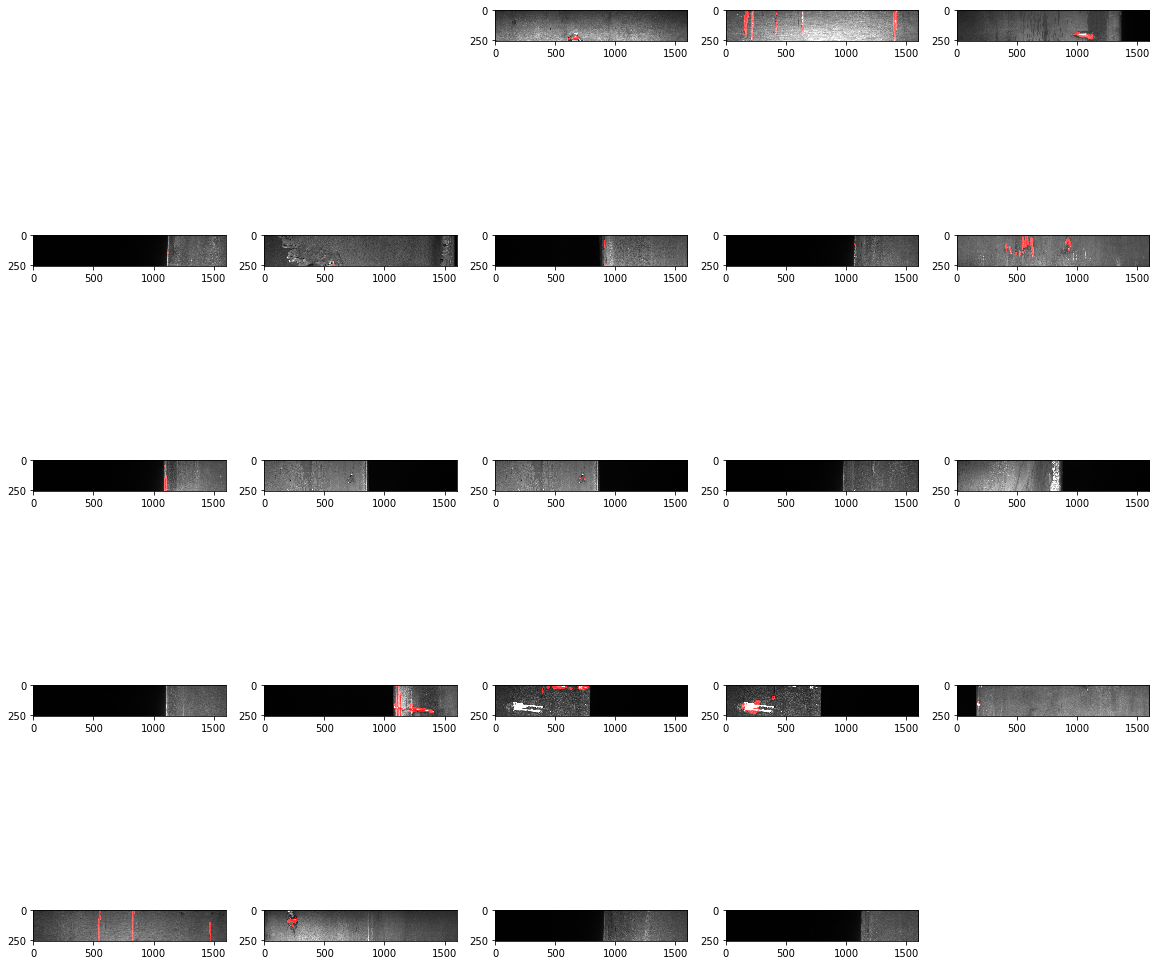

In [0]:
#https://www.kaggle.com/a03102030/practice-for-visualizing-mask
def rle2mask(rle,img):
	width=img.shape[0]
	length=img.shape[1]
	mask= np.zeros(width*length).astype(np.uint8)
	rle=rle.split()
	starts = rle[0::2]
	lengths = rle[1::2]
	for i in range(len(starts)):
		mask[int(starts[i]):(int(starts[i])+int(lengths[i]))]=1
	return np.flipud(np.rot90(mask.reshape(length, width), k=1 ) )

fig=plt.figure(figsize=(20,20))

for i in range(3,25):
	fig.add_subplot(5,5,i)
	Graph=results['ImageId_ClassId'].iloc[i].split('_')[0]
	img_new=cv2.imread("/content/drive/My Drive/assignment 28/test_images/"+Graph)
	img_new= cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB)
	mask = rle2mask(results['EncodedPixels'].iloc[i], img_new)
	img_new[mask==1,0] = 255
	plt.imshow(img_new)
plt.show()

## Final Function

In [0]:

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()


#Loading filter model to see if defect is present or not
filter_model = load_model('../input/weights/model_dense2.h5')
filter_model.summary()

#predict on data to see if defect is present or not
filter_test_set = filter_model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

# create a new column with the probability values and filter values with defect probability less than 0.5
test_unique['missing_per'] = filter_test_set
filtered_test_imgs = test_unique[test_unique['missing_per'] < 0.5]
print(filtered_test_imgs.shape)
filtered_test_imgs.head()
filtered_mask = test_df['ImageId'].isin(filtered_test_imgs["ImageId"].values)
test_withmask = test_df[filtered_mask].copy()
test_without_mask = test_df[~filtered_mask].copy()
test_without_mask['EncodedPixels'] = test_without_mask['EncodedPixels'].apply(
    lambda x: ' ')

test_withmask.reset_index(drop=True, inplace=True)
filtered_test_imgs.reset_index(drop=True, inplace=True)


#Classifying among 4 possible defect classes
model.load_weights('../input/weights/unet_1.h5')
test_predict = []

for i in range(0, filtered_test_imgs.shape[0], 300):
    batch_idx = list(
        range(i, min(filtered_test_imgs.shape[0], i + 300))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=filtered_test_imgs,
        shuffle=False,
        mode='predict',
        base_path='../input/severstal-steel-defect-detection/test_images',
        target_df=test_withmask,
        batch_size=1,
        n_classes=4
    )
    
    batch_pred_masks = model.predict_generator(
        test_generator,
        verbose=1
    )
    
    for j, b in tqdm(enumerate(batch_idx)):
        filename = filtered_test_imgs['ImageId'].iloc[b]
        image_df = test_withmask[test_withmask['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_predict.append(image_df)
        
        
final_results_pred = pd.concat([test_predict, test_without_mask])